In [1]:



# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-wordcloud/SKULL.png
/kaggle/input/image-wordcloud/THUMB.png
/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/bert-offline-local/local-tokenizer/tokenizer.json
/kaggle/input/bert-offline-local/local-tokenizer/tokenizer_config.json
/kaggle/input/bert-offline-local/local-tokenizer/special_tokens_map.json
/kaggle/input/bert-offline-local/local-tokenizer/vocab.txt
/kaggle/input/bert-offline-local/local-model/config.json
/kaggle/input/bert-offline-local/local-model/model.safetensors


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model from Kaggle input folder
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/bert-offline-local/local-tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/bert-offline-local/local-model")

# Move model to device and set to eval mode
model.to(device)
model.eval()


2025-05-23 18:28:08.858819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748024889.080672      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748024889.148222      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [3]:
fake=pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
true=pd.read_csv("../input/fake-and-real-news-dataset/True.csv")

In [4]:
fake["category"]=1
true["category"]=0

In [5]:
df=pd.concat([fake,true]).reset_index(drop=True)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

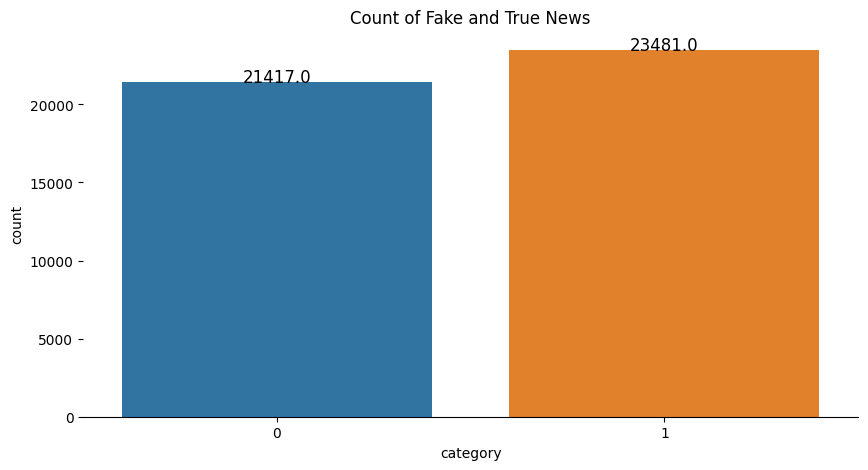

In [7]:
fig = plt.figure(figsize=(10,5))



graph = sns.countplot(x="category", data=df)
plt.title("Count of Fake and True News")

#removing boundary
graph.spines["right"].set_visible(False)
graph.spines["top"].set_visible(False)
graph.spines["left"].set_visible(False)

#annoting bars with the counts  
for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.2,height ,ha="center",fontsize=12)

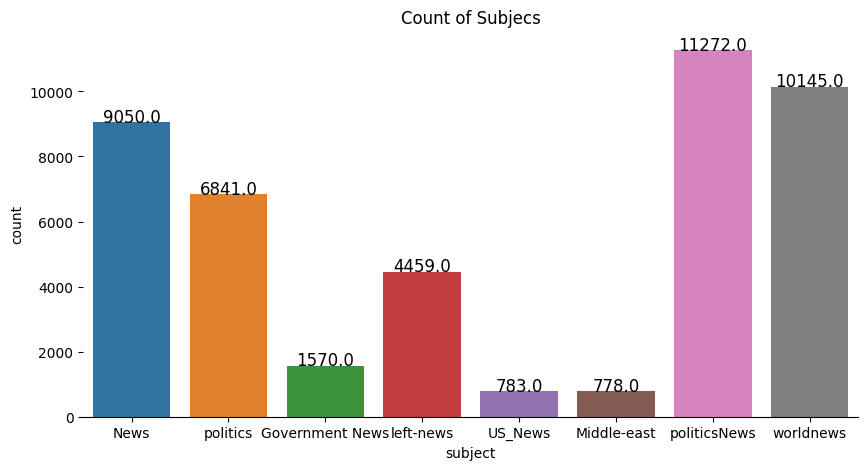

In [8]:
#creating a count plot for subject column
fig = plt.figure(figsize=(10,5))



graph = sns.countplot(x="subject", data=df)
plt.title("Count of Subjecs")

#removing boundary
graph.spines["right"].set_visible(False)
graph.spines["top"].set_visible(False)
graph.spines["left"].set_visible(False)

#annoting bars with the counts  
for p in graph.patches:
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.2,height ,ha="center",fontsize=12)

In [9]:
df.head()

,title,text,subject,date,category
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [10]:
df.isna().sum()*100/len(df)

title       0.0
text        0.0
subject     0.0
date        0.0
category    0.0
dtype: float64

In [11]:
blanks = []

# index, label and review of the doc
for index, text in df["text"].items():  # use .items() instead of .iteritems()
    if isinstance(text, str) and text.isspace():  # also check if text is a string
        blanks.append(index)

print(len(blanks))


631


In [12]:
#instead of dropping these values we are going to merge title with text

df["text"] =df["title"]+df["text"]

#we only need two columns rest can be ignored

df=df[["text","category"]]

In [13]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import spacy
import re

In [14]:
#loading spacy library
nlp=spacy.load("en_core_web_sm")

#creating instance
lemma=WordNetLemmatizer()

In [15]:
#creating list of stopwords containing stopwords from spacy and nltk

#stopwords of spacy
list1=nlp.Defaults.stop_words
print(len(list1))

#stopwords of NLTK
list2=stopwords.words('english')
print(len(list2))

#combining the stopword list
Stopwords=set((set(list1)|set(list2)))
print(len(Stopwords))

326
198
401


In [16]:
def clean_text(text):
    string = ""
    
    # removing any special characters
    text = re.sub(r"[-()\"#!@$%^&*{}?.,:]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)

    for word in text.split():
        if word not in Stopwords:
            string += lemma.lemmatize(word) + " "

    return string


In [17]:
#cleaning the whole data
df["text"]=df["text"].apply(clean_text)

In [18]:
from wordcloud import WordCloud

In [19]:
#creating more intiuive wordcloud 

#pil is pillow and used for image manupulation
from PIL import Image

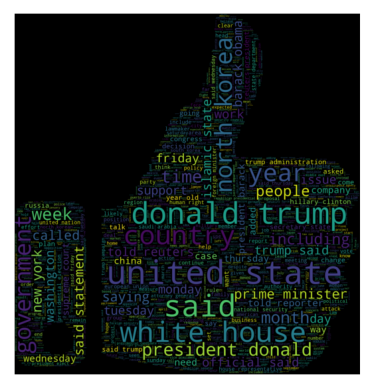

<Figure size 1000x1000 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from wordcloud import WordCloud

# Load and convert the thumbs-up image (make sure the path and filename are correct)
thumb = "/kaggle/input/image-wordcloud/THUMB.png"
icon = Image.open(thumb).convert("RGB")

# Create a white mask the same size as the image and paste the icon onto it at (0, 0)
mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=(0, 0))

# Convert the PIL image mask to a NumPy array for WordCloud
rgb_array = np.array(mask)

# Optional: Display the mask image to verify it loads correctly
plt.imshow(rgb_array)
plt.axis("off")
plt.show()

# Generate the word cloud using the mask
plt.figure(figsize=(10, 10))
Wc = WordCloud(mask=rgb_array, max_words=2000, width=1600, height=800, background_color="white")

# Generate word cloud text from 'true news' category (category == 0)
Wc.generate(" ".join(df[df.category == 0].text))




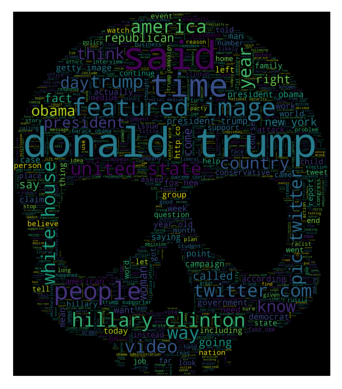

<Figure size 1500x1500 with 0 Axes>

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Path to your MASK.png image
mask_img_path = "/kaggle/input/image-wordcloud/SKULL.png"

# Open and convert the image to RGB
icon = Image.open(mask_img_path).convert("RGB")

# Create a white background mask and paste the icon
mask = Image.new(mode="RGB", size=icon.size, color=(255, 255, 255))
mask.paste(icon, box=(0, 0))

# Convert to numpy array for WordCloud mask
rgb_array = np.array(mask)

# Optional: display the mask image to verify
plt.imshow(rgb_array)
plt.axis("off")
plt.show()

# Generate word cloud using this mask (e.g., for category 1 or any category you want)
plt.figure(figsize=(15, 15))
Wc = WordCloud(mask=rgb_array, max_words=2000, width=1600, height=800, background_color="white")




In [22]:
#splitting the 
from sklearn.model_selection import train_test_split


X=df["text"] #feature 
y=df["category"] # traget

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
from torch.utils.data import DataLoader, Dataset

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare datasets and loaders
train_dataset = NewsDataset(X_train, y_train, tokenizer)
test_dataset = NewsDataset(X_test, y_test, tokenizer)

test_loader = DataLoader(test_dataset, batch_size=32)

# Prediction loop
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [24]:
#making prediction using the model
predictions = all_preds


In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.21      0.08      0.12      7039
           1       0.46      0.72      0.56      7778

    accuracy                           0.42     14817
   macro avg       0.33      0.40      0.34     14817
weighted avg       0.34      0.42      0.35     14817



In [26]:
#overall acuracy
print(metrics.accuracy_score(y_test,predictions))

0.4158736586353513


In [27]:
#confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[ 564 6475]
 [2180 5598]]


In [28]:
# Sample text to test
sample_text = "The Earth revolves around the Sun once every 300 days."


# Tokenize input (batch size 1)
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Inference (no_grad for efficiency)
with torch.no_grad():
    outputs = model(**inputs)

# Get logits and predicted class
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Map class id to label (0 = True, 1 = Fake) — based on your dataset labeling
label_map = {0: "True News", 1: "Fake News"}

print(f"Text: {sample_text}")
print(f"Predicted label: {label_map[predicted_class_id]}")




Text: The Earth revolves around the Sun once every 300 days.
Predicted label: True News


In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# Your model and tokenizer loading (update paths if needed)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/bert-offline-local/local-tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/bert-offline-local/local-model")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_news(text, threshold=0.75):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get logits from model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
    
    # Get predicted class and confidence
    confidence, predicted_class = torch.max(probs, dim=1)
    confidence = confidence.item()
    predicted_class = predicted_class.item()
    
    # Map label to human readable form
    label = "Fake News" if predicted_class == 1 else "True News"
    
    # Check confidence threshold
    if confidence < threshold:
        return f"Prediction uncertain (confidence={confidence:.2f}). Text might need manual review."
    else:
        return f"Predicted label: {label} (confidence={confidence:.2f})"

# Test examples
texts = [
    "The Earth revolves around the Sun once every 300 days.",
    "Water freezes at 0 degrees Celsius under normal atmospheric pressure.",
    "Vaccines cause autism according to recent studies.",
    "The Moon is Earth's only natural satellite."
]

for text in texts:
    print(f"Text: {text}")
    print(predict_news(text))
    print("-" * 50)


Text: The Earth revolves around the Sun once every 300 days.
Predicted label: True News (confidence=0.94)
--------------------------------------------------
Text: Water freezes at 0 degrees Celsius under normal atmospheric pressure.
Predicted label: True News (confidence=0.91)
--------------------------------------------------
Text: Vaccines cause autism according to recent studies.
Predicted label: True News (confidence=0.91)
--------------------------------------------------
Text: The Moon is Earth's only natural satellite.
Predicted label: True News (confidence=0.94)
--------------------------------------------------
